##### Test implementation of Function Tensor Train's basis functions 

In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import math
import numpy.polynomial.polyutils as pu

from abc import ABC, abstractmethod
from typing import Union, Tuple

# Get the path to the parent directory (one level up)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add 'src' directory to sys.path
src_path = os.path.join(parent_dir, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from basis_functions import legendre_recurrence, hermite_recurrence, OrthonormalLegendre1D, BSpline1D, Fourier1D,OrthonormalHermite1D

In [6]:
# Test implementation of Legendre recurrence

x = torch.tensor([0.])
# x = torch.tensor([0., 1., 2])

legendre_recurrence(x, 7)

tensor([[ 1.0000,  0.0000, -0.5000, -0.0000,  0.3750,  0.0000, -0.3125, -0.0000]],
       dtype=torch.float64)

In [14]:
# Test implementation of orthonormal Legendre basis
dimension = 3
d = 1
bases = [
        OrthonormalLegendre1D(dimension, domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 3


Text(0.5, 1.0, 'Orthonormal Legendre 1D')

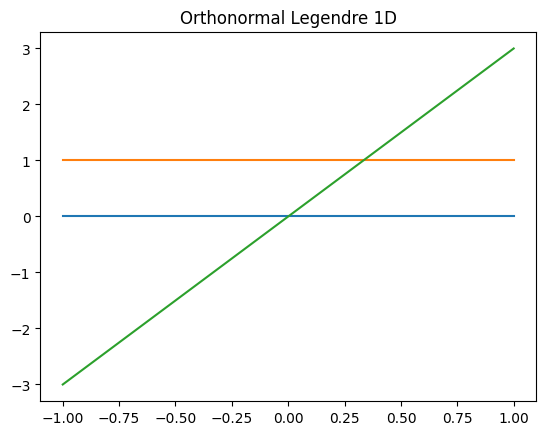

In [23]:
legendre = OrthonormalLegendre1D(dimension, domain=(-1., 1.))
x = np.linspace(-1., 1., 100)
y = [legendre(torch.tensor([x[i]]), m_derivative=1).squeeze(0) for i in range(100)]
plt.plot(x, y)
plt.title("Orthonormal Legendre 1D")

In [9]:
# Test implementation of B-spline basis
degree = 3
d = 2
bases = [
        BSpline1D(torch.linspace(-1, 1, 12), degree)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


Text(0.5, 1.0, 'B-Spline 1D')

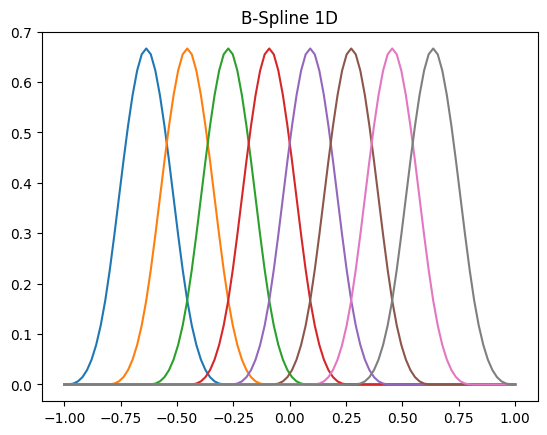

In [10]:
b_spline = BSpline1D(torch.linspace(-1., 1., 12), degree)
x = np.linspace(-1., 1., 100)
y = [b_spline(torch.tensor(x[i])) for i in range(100)]
plt.plot(x, y)
plt.title("B-Spline 1D")

In [11]:
# Test implementation of Fourier basis
dimension = 16
d = 2
bases = [
        Fourier1D(n=dimension, domain=(-2.5, 2.5))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 16


Text(0.5, 1.0, 'Fourier 1D')

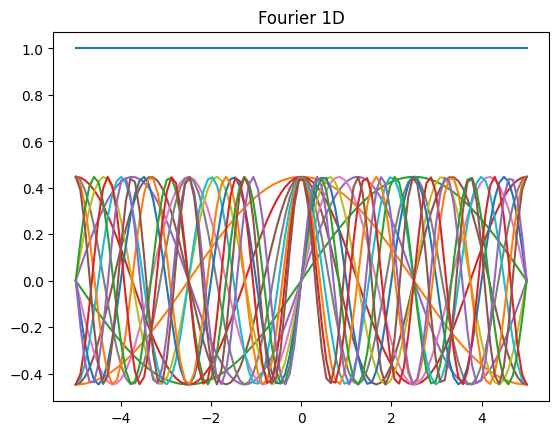

In [12]:
fourier = Fourier1D(dimension, domain=(-5., 5.), normalize=True, period=10)
x = torch.linspace(-5., 5., 100)
y = [fourier(torch.tensor([x[i]])).squeeze(0) for i in range(100)]
plt.plot(x, y)
plt.title("Fourier 1D")

In [20]:
# Test implementation of Hermite rerecurrence
x = torch.tensor([[0., 1., 2], [0., 1., 2.]])
x = torch.tensor([0., 1., 2])

hermite_recurrence(x, 5)

tensor([[  1.,   0.,  -1.,  -0.,   3.,   0.],
        [  1.,   1.,   0.,  -2.,  -2.,   6.],
        [  1.,   2.,   3.,   2.,  -5., -18.]], dtype=torch.float64)

In [21]:
# Test implementation of orthonormal Hermite basis
dimension = 6
d = 1
bases = [
        OrthonormalHermite1D(dimension)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 6


Text(0.5, 1.0, 'Orthonormal Hermite 1D')

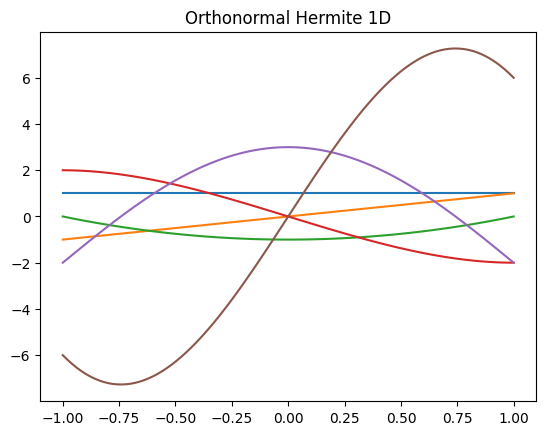

In [22]:
hermite = OrthonormalHermite1D(dimension)
x = np.linspace(-1., 1., 100)
y = [hermite(torch.tensor([x[i]])).squeeze(0) for i in range(100)]
plt.plot(x, y)
plt.title("Orthonormal Hermite 1D")

In [206]:
def legendre_recurrence(x, n_max, m_derivative=0):
    """
    Compute the Legendre polynomials up to degree n_max and their m-th derivatives
    at a given point or array of points x using PyTorch.

    Args:
        x (torch.Tensor): The point(s) at which the Legendre polynomials are to be evaluated.
        n_max (int): The maximum degree of Legendre polynomials to compute.
        m_derivative (int): The order of the derivative to compute.

    Returns:
        torch.Tensor: A sequence of Legendre polynomial values or their derivatives of shape 
                      (batch_size, dimensionality, n_max+1), evaluated at point(s) x.
                      The i-th entry of the output array corresponds to the Legendre 
                      polynomial of degree i or its m-th derivative.
    """
    # Ensure x is a torch tensor with dtype float64
    x = torch.as_tensor(x, dtype=torch.float64)

    # Add batch dimension if x is 1D
    added_batch_dim = False
    if x.ndim == 1:
        x = x.unsqueeze(0)
        added_batch_dim = True

    # Initialize tensors for Legendre polynomials
    batch_size, dims = x.shape
    polys = [torch.ones((batch_size, dims), dtype=torch.float64, device=x.device)]  # P_0(x) = 1

    if n_max >= 1:
        polys.append(x)  # P_1(x) = x

    # Compute the Legendre polynomials or their derivatives
    if m_derivative == 0:
        for n in range(1, n_max):
            p_next = ((2 * n + 1) * x * polys[-1] - n * polys[-2]) / (n + 1)
            polys.append(p_next)
            
        # Stack all computed polynomials along the last dimension
        result = torch.stack(polys, dim=-1)

    else:
        # Compute derivatives
        derivs = []
        for n in range(n_max + 1):
            if n < m_derivative:
                derivs.append(torch.zeros_like(x))
            elif n == m_derivative:
                d_next = (
                    math.factorial(2 * m_derivative) / (
                    (2 ** m_derivative) * math.factorial(m_derivative)
                    ) * torch.ones_like(x)
                )
                derivs.append(d_next)
            else:
                d_next = (
                    ((2 * n - 1) * x * derivs[n - 1] - (n - 1 + m_derivative) * derivs[n - 2]) /
                    (n - m_derivative)
                )
                derivs.append(d_next)

        # Stack all computed derivatives along the last dimension
        result = torch.stack(derivs, dim=-1)

    # Remove the added batch dimension if x was originally 1D
    if added_batch_dim:
        result = result.squeeze(0)

    return result


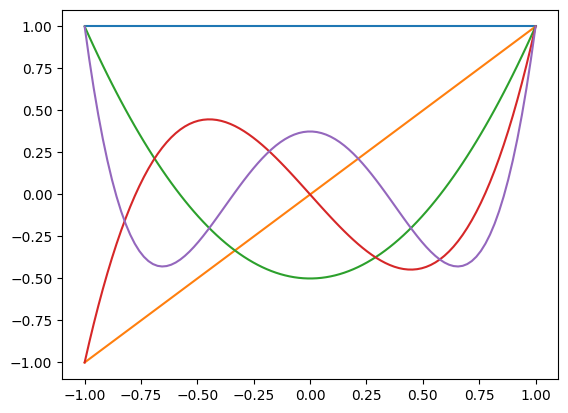

In [208]:
x = torch.linspace(-1, 1, 100)
y = [legendre_recurrence(torch.tensor([x[i]]), 4, m_derivative=0).squeeze(0) for i in range (len(x))]
plt.plot(x, y)

In [210]:
x = torch.tensor([0.])

legendre_recurrence(x, 4, m_derivative=0)

tensor([[ 1.0000,  0.0000, -0.5000, -0.0000,  0.3750]], dtype=torch.float64)